# Preparación
Se monta el sistema de archivos de google drive.


In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

2022-01-08 20:37:25.375186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 20:37:25.375990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 20:37:25.376435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 20:37:25.376974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 20:37:25.377505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

'/device:GPU:0'

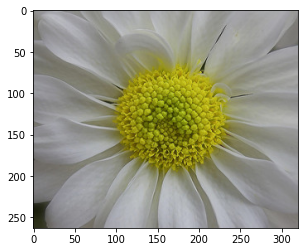

In [9]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('../input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg', 'r')
imshow(np.asarray(pil_im))



# Carga del dataset

In [10]:
image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/flowers-recognition/flowers",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/flowers-recognition/flowers",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


# Modelo

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten, BatchNormalization

In [12]:
model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1,
                    input_shape=(150, 150, 3)))


model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])



# Visualización del modelo

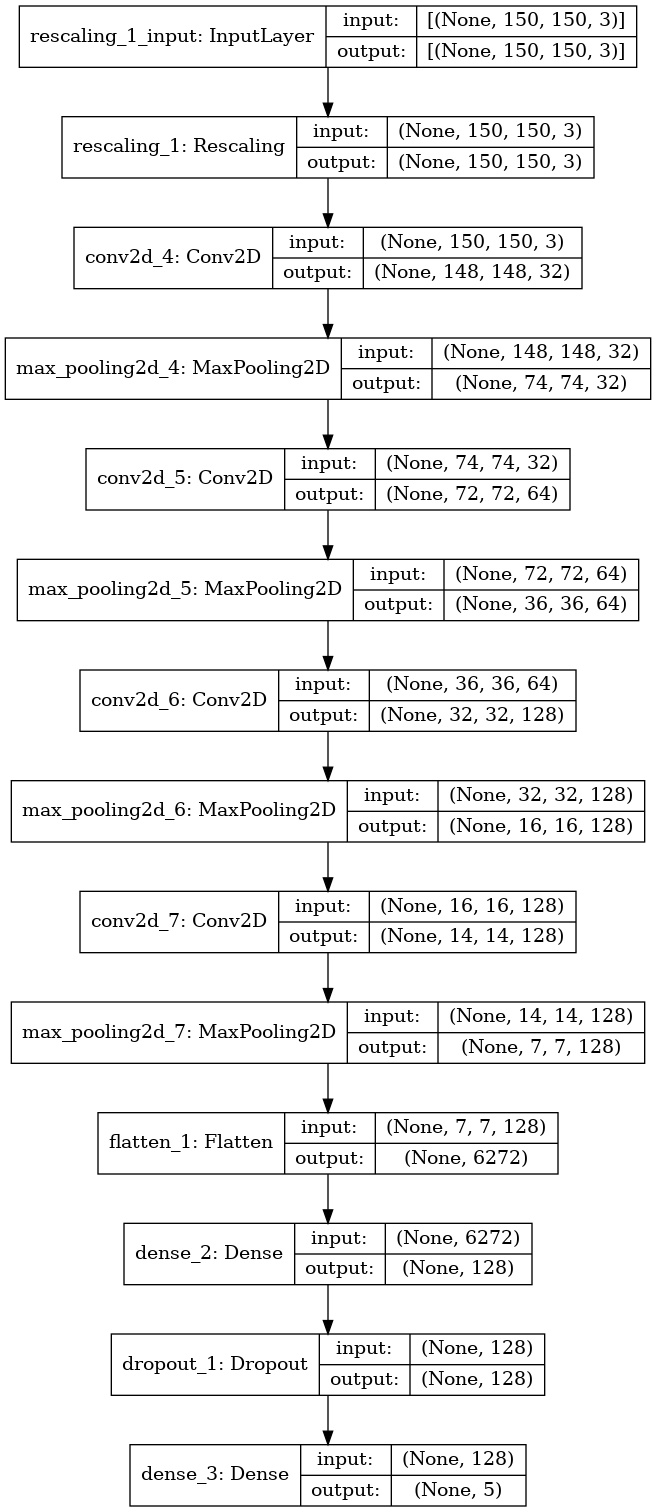

In [13]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True,
           show_layer_names=True)

# Entrenamiento

In [14]:
from keras.callbacks import EarlyStopping

epochs = 150

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10,
                   restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/150
108/108 [==============================] - 11s 89ms/step - loss: 1.3406 - accuracy: 0.4076 - val_loss: 1.1891 - val_accuracy: 0.5006
Epoch 2/150
108/108 [==============================] - 7s 58ms/step - loss: 1.1147 - accuracy: 0.5307 - val_loss: 1.0471 - val_accuracy: 0.5597
Epoch 3/150
108/108 [==============================] - 7s 61ms/step - loss: 0.9719 - accuracy: 0.6118 - val_loss: 0.9049 - val_accuracy: 0.6477
Epoch 4/150
108/108 [==============================] - 7s 58ms/step - loss: 0.8390 - accuracy: 0.6801 - val_loss: 0.8823 - val_accuracy: 0.6732
Epoch 5/150
108/108 [==============================] - 6s 55ms/step - loss: 0.7687 - accuracy: 0.7111 - val_loss: 0.8103 - val_accuracy: 0.7034
Epoch 6/150
108/108 [==============================] - 7s 56ms/step - loss: 0.6939 - accuracy: 0.7348 - val_loss: 0.8592 - val_accuracy: 0.6895
Epoch 7/150
108/108 [==============================] - 7s 62ms/step - loss: 0.6434 - accuracy: 0.7487 - val_loss: 0.8568 - val_accuracy

# Gráfica de evolución de pérdida y exactitud durante el entrenamiento

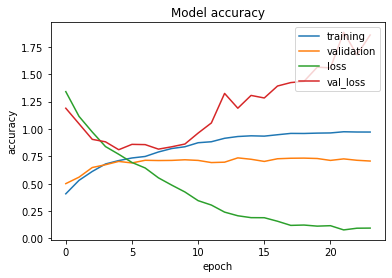

In [15]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss', 'val_loss'], loc='upper right')
plt.show()

# Evaluación de los resultados

              precision    recall  f1-score   support

           0     0.7445    0.6986    0.7208       146
           1     0.8034    0.8069    0.8051       233
           2     0.5497    0.6975    0.6148       119
           3     0.8733    0.7616    0.8137       172
           4     0.6859    0.6788    0.6823       193

    accuracy                         0.7358       863
   macro avg     0.7314    0.7287    0.7274       863
weighted avg     0.7461    0.7358    0.7389       863



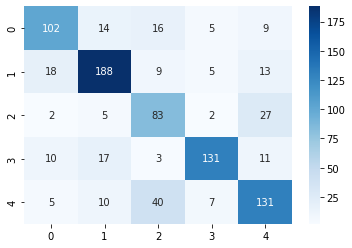

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [17]:
img = keras.preprocessing.image.load_img(
    '../input/flowers-recognition/flowers/daisy/10172636503_21bededa75_n.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1
